# Fourier Optics - The sampling of the PSF

The topic of Fourier Optics and the PSF can sometimes be tricky when you use the (discrete) Fast Fourier Transform. Specially if you want to be consistent with your pixel $\textbf{sampling}$, it is not trivial to know what the scale of your image pixels is. You have to play around with the number of pixels in your array $N$, the size of your pupil aperture $D$, the total size of the whole pupil array $l$ and the wavelength $\lambda$, plus you have to alternate between the $\textit{pupil}$ plane and the $\textit{image}$ plane. 

Therefore, I have created this Jupyter Notebook for those who always struggle with this stuff (myself included). A great deal of inspiration was taken from this blog post: http://www.strollswithmydog.com/wavefront-to-psf-to-mtf-physical-units/

Just to clarify the notation, the $\textit{pupil}$ coordinates are ($u$, $v$) while the $\textit{image}$ coordinates are ($x$, $y$). The number of pixels in both pupil and image arrays is $N$, the diameter of the telescope aperture is $D_u$, the pupil array spans a physical length of $l_u > D_u$

The main question I want to clarify with this notebook is: 

#### "How do need to set up your pupil masks ($N, D_u, l_u$) such that you are sampling the PSF with a certain angular scale $dx$ in mili-arcseconds [mas] (at a wavelength $\lambda$)

For this example we will use the dimensions of the Extremely Large Telescope (ELT), which means $D_u=39$ meters.


## First things first. What governs the PSF sampling?

Basic Fourier Optics tells us that the ratio between the diameter of our aperture $D_u$ and the physical size of our pupil array $l$ determines the $\textbf{sampling}$ $du$ of the PSF:

\begin{equation}
\epsilon = \frac{D_u}{l_u}
\end{equation}

The larger $l_u$ is with respect to our telescope diameter $D_u$, the finer the PSF sampling will be. If $l_u \simeq D_u$ the PSF sampling will be coarse and we will not discern its shape properly.

It is important to note that $N$ does not appear in the formula. In other words, for a given ratio $\epsilon$, changing the total number of pixels $N$ does not modify the PSF sampling, it only affects the overall size of the arrays by $\textbf{padding}$ the result of the Fourier transform with zeros. So we can mostly forget about $N$, except for the fact that if we use too small a number of pixels our pupil masks will not look circular, but very "pixelated" versions of circles.

Once we have explained this, we can run through an example of PSF propagation and see where that leads us.


In [145]:
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt

ARCSECS_IN_A_RAD = 206265    # Number of arcseconds in a radian

In [155]:
N_pix = 1024
D = 39.               # ELT diameter: 39 [meters]
wave = 1.5e-6         # Wavelength: 1.5 [microns]
l_u0 = 5.*D           # Place-holder for the physical length l_u

## Pupil sampling $du$

Let's start recalling what we know about things in the $\textit{pupil}$ plane. If our pupil array covers a total physical length of $l_u$ meters, the pupil sampling ("How many meters does each pixel cover?") is given by

\begin{equation}
du = \frac{l_u}{N}
\end{equation}

Let's try an example with a place-holder $l_u$ of 5 times the diameter of the ELT. 

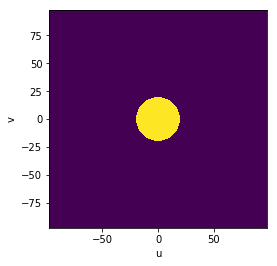

Total physical length = 195.0 [m]
Number of pixels = 1024 [pixels]
Sampling the Pupil with du = 0.190430 [m/pixel]


In [156]:
# Pupil coordinates (u, v)
u_min, u_max = -l_u0/2., l_u0/2.
u = np.linspace(u_min, u_max, N_pix)
v = u
uu, vv = np.meshgrid(u,v)

# Pupil mask
pupil_mask = uu**2 + vv**2 <= (D/2.)**2

plt.figure()
plt.imshow(pupil_mask, extent=(u_min, u_max, u_min, u_max))
plt.xlabel('u')
plt.ylabel('v')
plt.show()

# Sampling du
du = l_u0 / N_pix
print('Total physical length = %.1f [m]' %l_u0)
print('Number of pixels = %d [pixels]' %N_pix)
print('Sampling the Pupil with du = %f [m/pixel]' %du)

In this case our pixels in the $\textit{pupil}$ plane have a physical scale of round 0.20 meters. That is pretty straightforward, but when we move to the $\textit{image}$ plane, how does that physical scale translate into angular units?

## The PSF scale

Let us define our PSF according to the formulas of Fourier propagation. Because the arrays are pretty large (1024x1024) and are mostly empty, we will have to zoom in around the PSF and display only a small amount of pixels

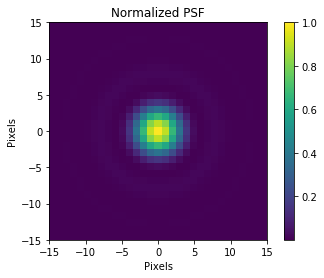

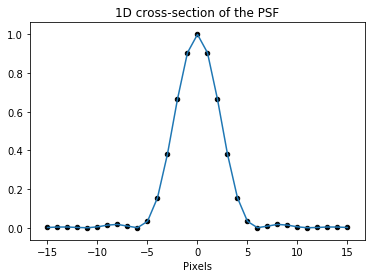

In [157]:
def compute_PSF(pupil_mask, wave):
    phase = 2*np.pi * 1j * pupil_mask / wave
    pupil_function = pupil_mask * np.exp(phase)
    electric_field = fftshift(fft2(pupil_function))
    PSF = (np.abs(electric_field))**2
    PSF /= PSF.max()
    return PSF

# Parameters used to zoom into the center of the PSF array
PIX = 15
min_pix, max_pix = N_pix//2 - PIX, N_pix//2 + PIX + 1
pixels = np.linspace(-PIX, PIX, 2*PIX+1).astype(int)

# Propagate to Image Plane
psf = compute_PSF(pupil_mask, wave)

# Show a zoom of the PSF array
psf_zoom = psf[min_pix:max_pix, min_pix:max_pix]
plt.figure()
plt.imshow(psf_zoom, extent=(-PIX, PIX, -PIX, PIX))
plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Normalized PSF')
plt.show()

# Plot a 1D profile of the PSF
psf_1D = psf[N_pix//2, min_pix:max_pix]
plt.figure()
plt.plot(pixels, psf_1D)
plt.scatter(pixels, psf_1D, s=20, color='Black')
plt.xlabel('Pixels')
plt.title('1D cross-section of the PSF')
plt.show()

We can see that the PSF is pretty well sampled in this case because the ratio $\epsilon = D_u/l_u= 0.20$ is fairly small

## Image (PSF) sampling $dx$

It is clear that after the Fourier propagation to the Image Plane (x, y) our PSF array will cover $N$ pixels in total. But what is the $\textbf{sampling}$ $dx$ of those pixels in terms of angular distance? In other words:

#### For a given $l_u$ and $D_u$ what is the pixel scale in mili-arcseconds (mas) in the image plane?

The formula for the pixel scale $dx$ [m] is given below including the dependency on the focal length $f$ of the telescope:

\begin{equation}
dx = \frac{\lambda \cdot f}{l_u}
\end{equation}

In our case, we are interested in neither the scale in meters nor the focal length, because what we want is the scale $dx$ in $\textbf{angular}$ units (mili-arcseconds) so we can forget about the $f$ in the formula. According to that, we can derive our current pixel scale

In [158]:
# Image sampling dx
dx_rad = wave / l_u0    # dx in [rad]
dx_mas = dx_rad * ARCSECS_IN_A_RAD *1000

print('For a physical length = %.1f [m]' %l_u0)
print('With a diameter = %.1f [m]' %D)
print('At a wavelength of = %.1f [microns]' %(1e6*wave))
print('Each pixel covers = %.2f [mas]' %dx_mas)

For a physical length = 195.0 [m]
With a diameter = 39.0 [m]
At a wavelength of = 1.5 [microns]
Each pixel covers = 1.59 [mas]


So apparently, our pixels in the $\textit{image}$ plane cover slightly over 1 and a half mili-arcseconds. First of all, let's check if our results are consistent. According to diffraction theory, the first 0 of the PSF happens at:

\begin{equation}
1.22 \frac{\lambda}{D_u} [rad]
\end{equation}

This means that for the ELT ($D_u = 39$ m), at a wavelength of 1.5 microns, the distance between the peak of the PSF and the first zero is:

In [159]:
airy_distance = 1.22 * wave / D     #[rad]
airy_distance_mas = airy_distance * ARCSECS_IN_A_RAD * 1000

print('The Airy distance for the ELT is %.2f [mas]' %airy_distance_mas)


The Airy distance for the ELT is 9.68 [mas]


So around 10 mili-arcseconds.
According to our previous results: our pixels have a certain $\textbf{scale}$ (in mas) and we can count $\textbf{how many pixels}$ does the Airy ring cover from our PSF plot. Combining those two values we get a result that's pretty much in accordance with the theoretical value that we derived above.

In [151]:
pixels_in_Airy = 6    # Judged from the PSF plot
airy_covers = pixels_in_Airy * dx_mas
print('The Airy pattern should cover %.2f [mas]' %airy_covers)

The Airy pattern should cover 9.52 [mas]


This confirms that the way we are computing the pixel scale is correct but it does not answer our main question...

## When you want to fix the Pixel scale

For the analysis above we used a place-holder value for the physical length $l_u$ and worked out what the pixel scale is in mili-arcseconds. But what if we have a prescribed pixel $\textbf{scale}$ that we want to achieve. In that case, the physical length $l_u$ is an unknown parameter that we need to compute

\begin{equation}
l_u = \frac{\lambda}{dx}
\end{equation}

In this case, for $\textbf{4-mas}$ pixels, the physical length $l_u$ of our pupil arrays is around 77

In [160]:
spaxel_scale = 4.     # 4 mili-arcseconds per pixels
spaxel_rad = spaxel_scale / 1000 / ARCSECS_IN_A_RAD
l = wave / spaxel_rad

print('For a fixed Pixel Scale of %d [mas/pixel], the required length l = %.2f [m]' %(spaxel_scale, l))
print('%.2f times the ELT diameter' %(l/D))

For a fixed Pixel Scale of 4 [mas/pixel], the required length l = 77.35 [m]
1.98 times the ELT diameter


Using that value, we can now re-define our pupil arrays and repeat the calculations to see how the PSF looks like when we sample it with 4-mas pixels

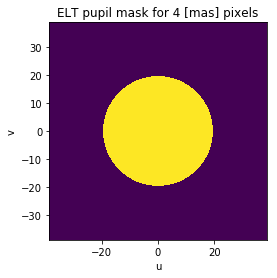

In [161]:
# Pupil coordinates (u, v)
u_min, u_max = -l/2., l/2.
u = np.linspace(u_min, u_max, N_pix)
v = u
uu, vv = np.meshgrid(u,v)

# Pupil mask
new_pupil_mask = uu**2 + vv**2 <= (D/2.)**2

plt.figure()
plt.imshow(new_pupil_mask, extent=(u_min, u_max, u_min, u_max))
plt.xlabel('u')
plt.ylabel('v')
plt.title('ELT pupil mask for %d [mas] pixels' %spaxel_scale)
plt.show()




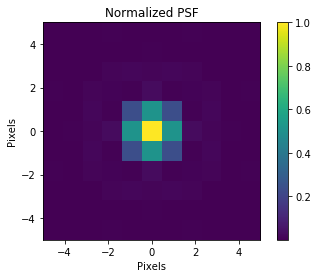

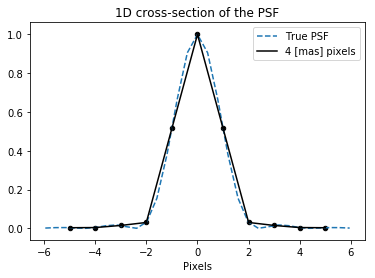

In [162]:
PIX = 5
min_pix, max_pix = N_pix//2 - PIX, N_pix//2 + PIX + 1
new_pixels = np.linspace(-PIX, PIX, 2*PIX+1).astype(int)

# Propagate to Image Plane
new_psf = compute_PSF(new_pupil_mask, wave)

# Show a zoom of the PSF array
psf_zoom = new_psf[min_pix:max_pix, min_pix:max_pix]
plt.figure()
plt.imshow(psf_zoom, extent=(-PIX, PIX, -PIX, PIX))
plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Normalized PSF')
plt.show()

rescaled_pixels = pixels * dx_mas / spaxel_scale

# Plot a 1D profile of the PSF
new_psf_1D = new_psf[N_pix//2, min_pix:max_pix]
plt.figure()
plt.plot(rescaled_pixels, psf_1D, linestyle='--', label='True PSF')
plt.plot(new_pixels, new_psf_1D, color='Black', label='%d [mas] pixels' %spaxel_scale)
plt.scatter(new_pixels, new_psf_1D, s=20, color='Black')
plt.xlabel('Pixels')
plt.legend()
# plt.ylim([0, 1.2])
plt.title('1D cross-section of the PSF')
plt.show()

## Conclusions

We can clearly see that in this case, as our pixels occupy 4 mas, we need around 2.5 pixels to cover the distance from the peak of the PSF to the first zero, which is consistent with the idea that at this wavelength the PSF spans 10 mas